In [1]:
from model import run_exp
import utils as utl

INFO       Cache size for target 'cython': 186454705474 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\spillern\.cython\brian_extensions' directory. [brian2]


# computational set up

In [2]:
# set up environment
path_comp = './2023_03_23_completeness_630_final.csv'
path_con = './2023_03_23_connectivity_630_final.parquet'
path_res = './results/example/'

config = {
    'path_comp' : path_comp, 
    'path_con'  : path_con, 
    'path_res'  : path_res,
    'n_proc'    : 15,
}

In [3]:
# custon neuron names
path_name = './flywire_ids_630.xlsx'

# sheet names of the xls file to include
sheets_pair = [ # pair of neurons (left+right per row)
    'stop',
    'walk',
    'walk_outputs',
    ]

sheets_single = [ # single neurons (one per row)
    # 'sugar', 
    # 'ovidn', 
    # 'bitter', 
    ]

name2flyid = utl.create_name_dict(path_name, path_comp, sheets_pair, sheets_single)

INFO: Loaded sheets ...
      ... stop
      ... walk
      ... walk_outputs

INFO: All names are unique

INFO: All IDs are unique

Declared 76 names for neurons

INFO: IDs appear to match with ./2023_03_23_completeness_630_final.csv



In [4]:
# lists of neuron groups
l_p9 = ['P9_l', 'P9_r']
l_bb = ['BB_r', 'BB_l']
l_cdn = ['P9-cDN1_l', 'P9-cDN1_r']

# run experiments

In [5]:
# P9 activation
instructions = [ 
    (0, 'stim', l_p9), 
    (1, 'end', [])
    ]

run_exp(exp_name='P9', exp_inst=instructions, name2flyid=name2flyid, **config)

>>> Experiment:     P9
    Output files:   results\example\P9.parquet
                    results\example\P9.pickle
    Instructions:
           0 |  stim | P9_l P9_r
           1 |   end | 
    Elapsed time:   170 s


In [6]:
# P9 + BB
instructions = [ 
    (0, 'stim', l_p9), 
    (0.25, 'stim', l_bb),
    (0.75, 'slnc', l_bb),
    (1, 'end', []),
    ]
run_exp(exp_name='P9+BB_slnc', exp_inst=instructions, name2flyid=name2flyid, **config)

>>> Experiment:     P9+BB_slnc
    Output files:   results\example\P9+BB_slnc.parquet
                    results\example\P9+BB_slnc.pickle
    Instructions:
         0.0 |  stim | P9_l P9_r
        0.25 |  stim | BB_r BB_l
        0.75 |  slnc | BB_r BB_l
         1.0 |   end | 
    Elapsed time:   57 s


In [7]:
# changing model parameters
from model import default_params as params
from brian2 import Hz

instructions = [ 
    (0, 'stim', l_p9), 
    (1, 'end', [])
    ]

params['r_poi'] = 250 * Hz

run_exp(exp_name='P9_ultra', exp_inst=instructions, name2flyid=name2flyid, **config, params=params)

>>> Experiment:     P9_ultra
    Output files:   results\example\P9_ultra.parquet
                    results\example\P9_ultra.pickle
    Instructions:
           0 |  stim | P9_l P9_r
           1 |   end | 
    Elapsed time:   86 s


# Process results

In [5]:
# load experiments
outputs = [
    './results/example/P9.parquet',
    './results/example/P9+BB_slnc.parquet',
]

df_spkt = utl.load_exps(outputs)
df_rate, df_std = utl.get_rate(df_spkt, duration=1)

df_rate = utl.rename_index(df_rate, name2flyid)
df_std = utl.rename_index(df_std, name2flyid)

utl.save_xls(df_rate, './results/example/rate.xlsx')
utl.save_xls(df_std, './results/example/rate_std.xlsx')

INFO: saving 2 experiments to ./results/example/rate.xlsx
INFO: saving 2 experiments to ./results/example/rate_std.xlsx


INFO: setting figsize to (18, 4)


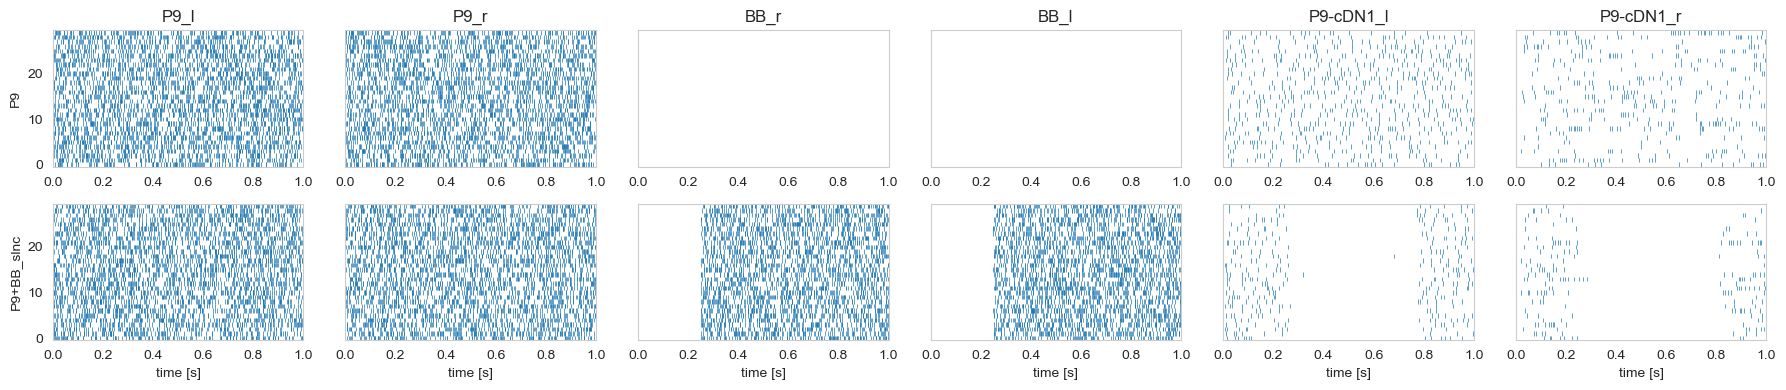

In [6]:
# raster plots
neu = l_p9 + l_bb + l_cdn
utl.plot_raster(df_spkt, neu, name2flyid=name2flyid, xlims=(0, 1))

INFO: setting figsize to (10, 4)


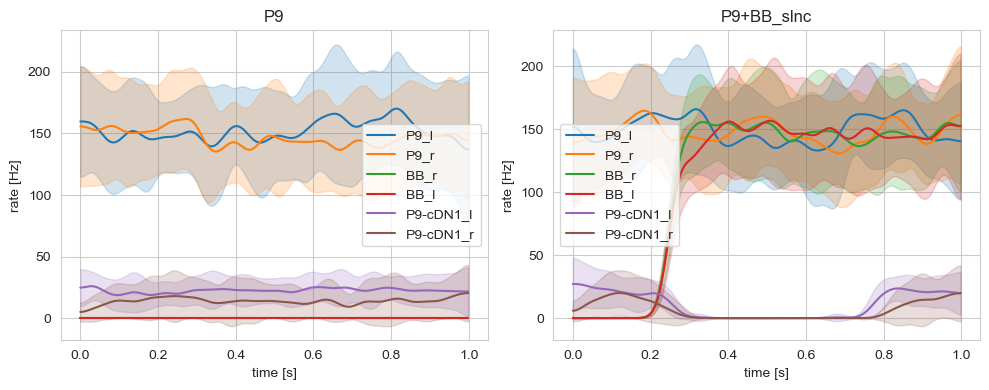

In [7]:
# firing rates
utl.plot_rate(df_spkt, neu, xlims=(0, 1), name2flyid=name2flyid)

In [15]:
# select top 20 neurons
top20 = df_rate.sort_values(by='P9', ascending=False).head(20)
top20

exp_name,P9,P9+BB_slnc
flyid,,
P9_l,151.900000,149.200000
P9_r,147.033333,147.600000
720575940637718505,55.533333,55.500000
720575940619876884,50.000000,48.966667
720575940631924584,39.800000,40.000000
720575940631283512,37.100000,35.600000
720575940632042148,37.033333,36.633333
720575940623455239,31.666667,34.766667
DNa06_l,29.000000,18.600000


INFO: setting figsize to (10, 6.0)


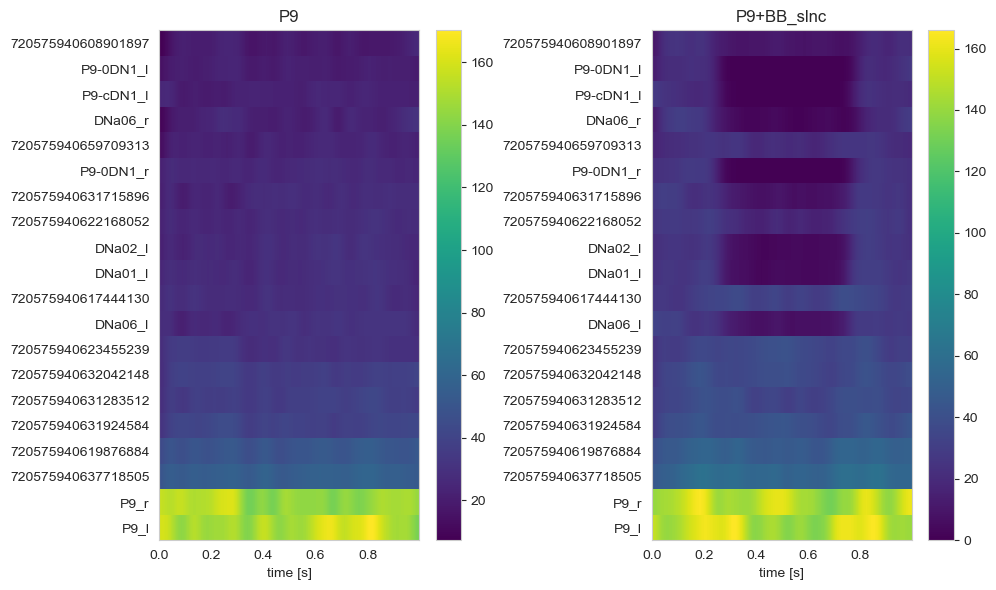

In [16]:
# plot heatmap
utl.plot_rate_heatmap(df_spkt, top20.index, xlims=(0, 1), name2flyid=name2flyid, do_zscore=False)

# Graphs representation

In [15]:
# load connectome into graph
G = utl.get_full_graph(path_comp, path_con)
print(len(G.nodes))

127400


In [16]:
# select subgraph based on simulation results
output = './results/example/P9.parquet'
utl.write_graph(G, output, name2flyid=name2flyid)

INFO: writing graph file results\example\P9.gexf
